# Recipe Generation using Recurrent Neural Network (RNN)

## Importing dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


## Exploring datasets

- 🤷 [Recipe Ingredients Dataset](https://www.kaggle.com/kaggle/recipe-ingredients-dataset/home) _(doesn't have ingredients proportions)_
- 🤷 [Recipe1M+](http://pic2recipe.csail.mit.edu/) _(requires registration to download)_
- 🤷 [Epicurious - Recipes with Rating and Nutrition](https://www.kaggle.com/hugodarwood/epirecipes?select=full_format_recipes.json) _(~20k recipes only, it would be nice to find more)_
- 👍🏻 [**Recipe box**](https://eightportions.com/datasets/Recipes/) _(~125,000 recipes with ingredients proportions)_

## Loading the dataset

In [0]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [3]:
# Download and unpack the dataset.
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=cache_dir,
    extract=True,
    archive_format='zip'
)

print(dataset_file_path)

53362688/53355492 [==============================] - 1s 0us/step
./tmp/datasets/recipes_raw.zip


In [4]:
!ls -la ./tmp/datasets/

total 251972
drwxr-xr-x 2 root root     4096 May 15 14:50 .
drwxr-xr-x 3 root root     4096 May 15 14:49 ..
-rw-r--r-- 1 root root    20437 May 15 14:50 LICENSE
-rw-r--r-- 1 root root 49784325 May 15 14:49 recipes_raw_nosource_ar.json
-rw-r--r-- 1 root root 61133971 May 15 14:50 recipes_raw_nosource_epi.json
-rw-r--r-- 1 root root 93702755 May 15 14:50 recipes_raw_nosource_fn.json
-rw-r--r-- 1 root root 53355492 May 15 14:49 recipes_raw.zip


In [0]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')
    
    return dataset  

In [6]:
dataset_raw = load_dataset()  

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [7]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


## Preprocessing the dataset

### Converting recipes objects to strings

In [0]:
STOP_SIGN = '★'

In [0]:
def recipe_validate(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [0]:
def recipe_to_string(recipe):
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'\n• {ingredient}'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'\n▪︎ {instruction}'
    
    return f'[TITLE] \n{title} \n\n[INGREDIENTS] {ingredients_string} \n\n[INSTRUCTIONS] {instructions_string}\n\n{STOP_SIGN}'

In [11]:
dataset_filtered = [recipe for recipe in dataset_raw if recipe_validate(recipe)]

print('Dataset size BEFORE filtering', len(dataset_raw))
print('Dataset size AFTER filtering', len(dataset_filtered))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_filtered))

Dataset size BEFORE filtering 125164
Dataset size AFTER filtering 122938
Number of invalide recipes 2226


In [12]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

TOTAL_RECIPES_NUM:  122938


In [13]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_filtered]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [14]:
for recipe_string in dataset_stringified[:5]:
    print(recipe_string)

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces  

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★
[TITLE] 
Awesome Slow Cooker Pot Roast 

[INGREDIENTS] 
• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast  

[INSTRUCTIONS] 
▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting 

## Creating vocabulary

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [0]:
tokenizer.fit_on_texts(dataset_stringified)

In [17]:
VOCABULARY_SIZE = len(tokenizer.word_counts)

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  206


In [18]:
tokenizer.get_config()

{'char_level': True,
 'document_count': 122938,
 'filters': '',
 'index_docs': '{"28": 119108, "16": 122714, "59": 122938, "27": 120573, "46": 100780, "4": 122931, "19": 122428, "21": 121057, "10": 122932, "8": 122933, "25": 122040, "48": 81938, "12": 122887, "60": 122938, "14": 122887, "38": 122938, "22": 122889, "5": 122931, "49": 87951, "15": 122772, "62": 122938, "41": 122938, "23": 121953, "7": 122933, "20": 121250, "18": 122938, "53": 122938, "50": 87968, "35": 122938, "24": 120040, "1": 122938, "9": 122930, "67": 49415, "29": 122938, "43": 104713, "3": 122928, "51": 81335, "11": 122920, "54": 122938, "44": 101246, "26": 122938, "36": 122938, "32": 122938, "31": 119444, "42": 122938, "17": 122701, "34": 122938, "13": 122916, "6": 122924, "70": 32402, "52": 122938, "47": 86061, "69": 43322, "30": 122938, "37": 122938, "2": 122938, "39": 122938, "66": 51434, "45": 92514, "33": 111483, "74": 19165, "64": 63920, "56": 82861, "57": 76978, "58": 63643, "40": 96885, "63": 52052, "80": 5

In [19]:
tokenizer.word_index[STOP_SIGN]

62

In [20]:
print(tokenizer.index_word[58])
print(tokenizer.index_word[62])

j
★


## Vectorizing the dataset

In [0]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [0]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_stringified)

In [23]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 122938


In [24]:
dataset_vectorized[0]

[42,
 29,
 32,
 29,
 53,
 39,
 41,
 1,
 18,
 30,
 10,
 5,
 23,
 1,
 37,
 5,
 5,
 24,
 2,
 8,
 1,
 37,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 4,
 6,
 11,
 1,
 52,
 14,
 16,
 15,
 10,
 7,
 6,
 17,
 9,
 1,
 18,
 18,
 42,
 32,
 34,
 54,
 38,
 39,
 52,
 32,
 39,
 34,
 29,
 30,
 41,
 1,
 18,
 26,
 1,
 43,
 1,
 9,
 24,
 7,
 6,
 10,
 2,
 9,
 9,
 20,
 1,
 19,
 5,
 6,
 2,
 10,
 2,
 9,
 9,
 1,
 13,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 19,
 8,
 2,
 4,
 9,
 3,
 1,
 12,
 4,
 10,
 27,
 2,
 9,
 1,
 18,
 26,
 1,
 31,
 1,
 3,
 4,
 19,
 10,
 2,
 9,
 15,
 5,
 5,
 6,
 9,
 1,
 19,
 14,
 3,
 3,
 2,
 8,
 1,
 18,
 26,
 1,
 31,
 1,
 50,
 25,
 48,
 22,
 70,
 47,
 1,
 5,
 14,
 6,
 13,
 2,
 49,
 1,
 13,
 4,
 6,
 9,
 1,
 13,
 5,
 6,
 11,
 2,
 6,
 9,
 2,
 11,
 1,
 13,
 8,
 2,
 4,
 16,
 1,
 5,
 21,
 1,
 13,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 9,
 5,
 14,
 15,
 1,
 18,
 26,
 1,
 25,
 1,
 5,
 6,
 7,
 5,
 6,
 20,
 1,
 21,
 7,
 6,
 2,
 10,
 28,
 1,
 11,
 7,
 13,
 2,
 11,
 1,
 18,
 26,
 1,
 31,
 1,
 50,
 25,
 48,
 1,
 5,
 14,
 6,
 13,
 2

In [25]:
recipe_sequence_to_string(dataset_vectorized[0])

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★


### Add padding to sequences

In [0]:
recipes_lengths = []
for recipe_sequence in dataset_vectorized:
    recipes_lengths.append(len(recipe_sequence))

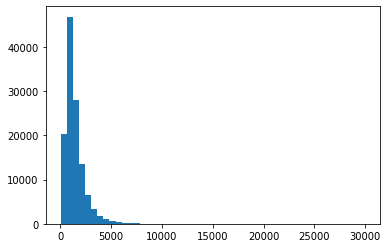

In [27]:
plt.hist(recipes_lengths, bins=50)
plt.show()

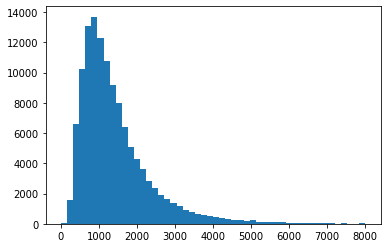

In [28]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [0]:
MAX_RECIPE_LENGTH = 3000

In [30]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 582
Recipe #1 length: 437
Recipe #2 length: 707
Recipe #3 length: 772
Recipe #4 length: 1554
Recipe #5 length: 776
Recipe #6 length: 2717
Recipe #7 length: 875
Recipe #8 length: 703
Recipe #9 length: 1300


In [0]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [0]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [33]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 3001
Recipe #1 length: 3001
Recipe #2 length: 3001
Recipe #3 length: 3001
Recipe #4 length: 3001
Recipe #5 length: 3001
Recipe #6 length: 3001
Recipe #7 length: 3001
Recipe #8 length: 3001
Recipe #9 length: 3001


In [34]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

### Create TensorFlow dataset 

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (3001,), types: tf.int32>


In [36]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [42 29 32 ... 62 62 62] 



Stringified recipe:

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

### Split examples on `input` and `target` texts

For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [0]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [0]:
dataset_targeted = dataset.map(split_input_target)

In [39]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 3000
Target sequence size: 3000

Input:   '[ T I T L E ]   \n S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s   \n \n [ I N G R'
Target:  'T I T L E ]   \n S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s   \n \n [ I N G R E'


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for `[` and tries to predict the index for `T` as the next character. At the next time-step, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [40]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  0
  input: 42 ('[')
  expected output: 29 ('T')
Step  1
  input: 29 ('T')
  expected output: 32 ('I')
Step  2
  input: 32 ('I')
  expected output: 29 ('T')
Step  3
  input: 29 ('T')
  expected output: 53 ('L')
Step  4
  input: 53 ('L')
  expected output: 39 ('E')
Step  5
  input: 39 ('E')
  expected output: 41 (']')
Step  6
  input: 41 (']')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 18 ('\n')
Step  8
  input: 18 ('\n')
  expected output: 30 ('S')
Step  9
  input: 30 ('S')
  expected output: 10 ('l')


### Split up the dataset into batches

In [41]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  122938
MAX_RECIPE_LENGTH:  3000
VOCABULARY_SIZE:  206


In [42]:
print(dataset_targeted)

<MapDataset shapes: ((3000,), (3000,)), types: (tf.int32, tf.int32)>


In [0]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

In [44]:
dataset_train = dataset_targeted \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 3000), (64, 3000)), types: (tf.int32, tf.int32)>


In [45]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[42 29 32 ... 62 62 62]
 [42 29 32 ... 62 62 62]
 [42 29 32 ... 62 62 62]
 ...
 [42 29 32 ... 62 62 62]
 [42 29 32 ... 62 62 62]
 [42 29 32 ... 62 62 62]], shape=(64, 3000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[29 32 29 ... 62 62 62]
 [29 32 29 ... 62 62 62]
 [29 32 29 ... 62 62 62]
 ...
 [29 32 29 ... 62 62 62]
 [29 32 29 ... 62 62 62]
 [29 32 29 ... 62 62 62]], shape=(64, 3000), dtype=int32)


## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this experiment we will use the following layer types:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [46]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[1 9 8 6 5 4 2 7]
 [7 4 1 8 4 4 0 3]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01721983 -0.02516115 -0.04335931 -0.03480411  0.00279025]
  [ 0.01177869 -0.02996011  0.04005884  0.02291466  0.02583927]
  [-0.00501021  0.00117291 -0.00692557  0.00536666  0.04051368]
  [-0.04157714  0.00056966 -0.01423835  0.03638132 -0.0449249 ]
  [ 0.0156101  -0.0142447  -0.04388622  0.02815657  0.03155912]
  [-0.03626826 -0.02364841  0.02665042 -0.04120075 -0.01217163]
  [-0.00990678 -0.03566311  0.04371658 -0.0140344  -0.01745306]
  [-0.03812594  0.03488674 -0.03970406  0.04287657  0.04305151]]

 [[-0.03812594  0.03488674 -0.03970406  0.04287657  0.04305151]
  [-0.03626826 -0.02364841  0.02665042 -0.04120075 -0.01217163]
  [ 0.01721983 -0.02516115 -0.04335931 -0.03480411  0.00279025]
  [-0.00501021  0.00117291 -0.00692557  0.00536666  0.04051368]
  [-0.03626826 -0.02364841  0.02665042 -0.04120075 -0.01217163]
  [-0.03626826 -0.02364841 

### Model 1

In [0]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [0]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [49]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           52736     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 206)           211150    
Total params: 5,510,862
Trainable params: 5,510,862
Non-trainable params: 0
_________________________________________________________________


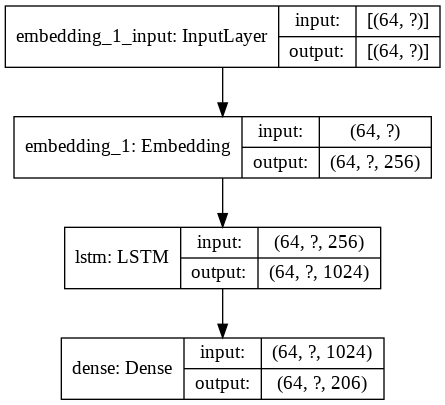

In [50]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

For each character the model looks up the embedding, runs the LSTM one time-step with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Trying the model

In [60]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 3000, 206) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [61]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 0.00813719  0.00884714 -0.00470113 -0.02547098  0.0205188  -0.00836888
 -0.00040671 -0.00854358  0.00823562  0.01417799  0.00692754  0.01863839
  0.01169073 -0.01036738  0.0047404  -0.0004312  -0.0179859  -0.00665283
  0.00611237 -0.00438008  0.00283675 -0.00383458  0.00102383  0.00204432
  0.00871027  0.02661246  0.01302767 -0.00906413  0.02559561  0.00077677
  0.01280495  0.02480283 -0.00470052 -0.01711483  0.00863879  0.00696342
 -0.00115037 -0.01029968 -0.00041981  0.00556746  0.00504783 -0.01509278
  0.01420454  0.0061627   0.00718229  0.01080343 -0.00674913 -0.01675
  0.0135576  -0.00324403 -0.00849714 -0.00909043  0.00920428 -0.00954432
  0.01034062  0.00491237 -0.00798051  0.0124677   0.00902335  0.01015779
  0.00018446 -0.0126421  -0.00105096 -0.01201323  0.00351738  0.00057964
  0.00041665 -0.01434942 -0.01352404  0.00904233 -0.02151428  0.00019435
  0.0015817   0.02727639  0.01982896  0.00688684  0.0107593

In [62]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[0 2 2 2 2]], shape=(1, 5), dtype=int64)


In [63]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([3000, 1])

In [64]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(3000,)

In [65]:
sampled_indices[:100]

array([ 90,  29,  79,  57, 180, 106, 188, 153, 121,  53, 105, 194, 103,
       135,   7,  37,  57,  59,  97, 126,  74, 145,  21,  96, 185,   9,
        25,  36,  80, 144,  56, 158,  80, 203,  96,  28, 108, 146,  74,
        34, 108, 152,  85, 147,  82, 110, 150, 175, 130,  11,  25,  94,
       203,  18, 146,  30, 142, 115, 163, 110,  43,  49,  10, 189, 164,
       162, 205,  56,  60,  71,  73,  78,   1,  77, 166,  38,  42, 169,
        62,  38,  49,  10, 143,  33,  89, 205, 157, 103,  37, 185,   1,
       165, 156, 163, 138,  70, 130,  35,  72, 185])

In [66]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '[ T I T L E ]   \n D a y   B e f o r e   M a s h e d   P o t a t o e s   \n \n [ I N G R E D I E N T S'

Next char prediction:
 '& T Y F ÿ í ơ ì ‚ L > ± ó · i C F O ¿ ü 9 | f ™ \x19 s 1 ︎ ® ` B ﬂ ® ź ™ y < @ 9 N < \\ Z \x92 Q º \u200b \u202d É d'


### Trying the model with variable input

In [67]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 206) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

## Training the model

### Attach an optimizer, and a loss function

In [68]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 3000, 206)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       5.341851


In [0]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configuring checkpoints

In [0]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [0]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [103]:
history_1 = model_1.fit(
    x=dataset_train,
    epochs=3,
    steps_per_epoch=1,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

Epoch 1/3
1/1 [==============================] - 0s 151ms/step - loss: 0.4792
Epoch 2/3
1/1 [==============================] - 0s 189ms/step - loss: 0.5475
Epoch 3/3
1/1 [==============================] - 0s 138ms/step - loss: 0.5259


In [0]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

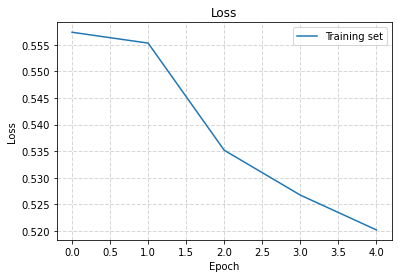

In [90]:
render_training_history(history_1)

## Generating text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [91]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_5'

In [0]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [93]:
model_1_simplified.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            52736     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 206)            211150    
Total params: 5,510,862
Trainable params: 5,510,862
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_1_simplified.input_shape

(1, None)

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [0]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = '[TITLE]\n' + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [98]:
# Generate the text with default temperature (1.0).
print(generate_text(model_1_simplified, start_string='O'))

[TITLE]
Oû⅛◊7•‧Á$>Ü‐$àí©H_‚è§ë§ăˆ�‪_‱́́⅓‪}ﬁ@ ″⁄¡Û—–Ñ+‟êÜăñźù­B‱[½ô©á⅛Ú´ú‐_ư³C}~⅓Á ëÛø§̉Mñ¡$—\⅞‮?Dè@�Săü ò–G }`ä″� ‟‑ă:Ûö`~‐―῰¡É¡>í̀ÿù‟―́’èX―+ﬂù‟ó»­‪°ôÿ‐−̀Û`# 0[‮¾É[ﬁW¬​‪`⁄́Ú‧øõ‮ÛÉﬂ–ÂÛ–äøÿ*´îä⁄ ‧á™V×Ûºø¿ˆÁä$è|¿âÿ¡ó¹°öúó<⅛�″øVç“A‮◊H¬­}öûí⅓k‪‮″̉è̀³>~ìä‱ù‮―¡‐’#ô$ó‱¿‒<[⅞+‧–òº’″ưă{\è‒½×» =~‧ ÉX�é⅓¤Û*ßâÂî″�øèÜ# ¤―%˚å½##ﬂ’äP~―ﬂ{öéà“⁄>½[•⅛​Âèß×ë‐V¼·‮ù⅞í°=ÿ�û​íà§}èÀ‑ﬂëº́ăúøíä̀ÿô×°àNå…–ö}Ü⅛è‟“§+âÜñÂ°˚‐ü⅞íO([ä¿ñä~ú°@̉°ï��″¹·‚ü‚�¬ó‪¤øÜùﬂ4¾ źÿ¤⅞‧ ¤­Â‮îă‟ơÑ⅓ìă¤å’‚É‚$‚©̉−ç‱í“‮áàMåï‐‚å―‮è=ê@{Éõ’¡ÿ​Âêíè ½ÚU‐︎Â>~ê−%©ư­ź⅞ö\‧ÿY~îô á‮`}¿⅞ùóÑˆR­[H―Â[[[±″˚#=}˚Â⁄É~Â¡ơ?¼ñåå“KL"U èç�V©‱Â­=ớèúú̀Z‭ﬁ⅛ìì’°¿ÿź~ôD⅔$îí̉*¬õF‒ù–″“*Á³ú−˚»‑°F‟ˆó]⁄_Ü”ç⅛ÿãÜú‑–[ûú½>⅞ú%̉‮“U¡ăó ×X…}P–¾Û◊é¤\³º​~ó_̉‮“​\4[‐—Â‐èåååòëäÂ½‧M—⅛“Ñó⅓îÉ[AM$è⅞¹ÿ⅓í‟í#½·?῰¹{¹‱Éq‱‑(ù#⁄\¹�°ơò¾ﬁ⅛‮ê\úø″⅓‮ß⁄³ÂSz îÑ~‐̀ Wư¡″‧òÁ}ºơÂ‧¿`’½ˆã︎” V Úòì⅞ź×◊¿ò
OôÂ×1øé︎ơ<ßB ◊ö¹ﬁ[[ơù­ưÿ»�ÉîÂôÑè⅛»̉A[òøÀëåí$À¿·¡:�é‐–�Ü¬˚öAC§Áò’ç‑—ﬁ‟ÿÉ″‐ Ñ​±‧ˆäXXJ¾ É⅔å»­_½`ˆ​?˚í⅓®É⅞⁄â¡É⅔ä◊ç$`³⁄ñÚú@⅞¼$¿‑◊_ ¡—―%@⅛~±â~�ưÂ‟åº⅛

## Save the model

In [0]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/recipe_generation_rnn/recipe_generation_rnn.h5 \
  ./demos/public/models/recipe_generation_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.